In [1]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))
from pathlib import Path

In [2]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as poly
import scipy
from scipy import integrate
import math
import matplotlib.pyplot as plt
import os
import varname

In [3]:
def get_names_normalized(df, names):
    for i in range(len(df.iloc[0])):
        if i != 0:
            names.append(df.iloc[0][i][df.iloc[0][i].find(':')+4:]\
                        + '_' + df.iloc[1][i][1:])
    return names

def load_and_clean(name):
    df = pd.read_excel(name)
    units = list(df.loc[1])

    if list(df.iloc[1]).count('min') == 1:
        properties = get_names_normalized(df, ['min'])
    elif list(df.iloc[1]).count('ml') == 1:
        properties = get_names_normalized(df, ['ml'])
    else:
        properties = list(df.loc[0])
        for ind, prop in enumerate(properties):
            if ind%2 == 0:
                name        = properties[ind][(properties[ind].rfind(':')+1):]
                abbrev_name = name[(name.find('_')+1):]
                units       = df.iat[1, ind]
            else:
                units       = df.iat[1, ind][(df.iat[1, ind].find(' ')+1):]
            properties[ind] = abbrev_name + '_' + units    

    df.columns = properties
    df.drop(labels=[0, 1], axis='index', inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

def align_yaxis_multiple(ax_list):
    y_lims = np.array([ax.get_ylim() for ax in ax_list])

    # force 0 to appear on both axes, comment if don't need
    y_lims[:, 0] = y_lims[:, 0].clip(None, 0)
    y_lims[:, 1] = y_lims[:, 1].clip(0, None)

    # normalize both axes
    y_mags = (y_lims[:,1] - y_lims[:,0]).reshape(len(y_lims),1)
    y_lims_normalized = y_lims / y_mags

    # find combined range
    y_new_lims_normalized = np.array([np.min(y_lims_normalized), 
                                      np.max(y_lims_normalized)])

    # denormalize combined range to get new axes
    new_lim = y_new_lims_normalized * y_mags
    for ax, lim in zip(ax_list, new_lim):
        ax.set_ylim(lim)
    ax.axhline(color='k')
    return

def add_fractions(ax, df, x_conversion=1, text=False, xlim_times=None):
    if 'Fractions_cv' in df.columns:
        frac_times = [x for x in df['Fractions_cv'] if str(x) != 'nan']
    elif 'Fractions_min' in df.columns:
        frac_times = [x*x_conversion for x in df['Fractions_min'] if str(x) != 'nan']
    elif 'Fractions_ml' in df.columns:
        frac_times = [x*x_conversion for x in df['Fractions_ml'] if str(x) != 'nan']
    else:
        print('No x-coordinates found')
        return
    
    frac_names = [x for x in df['Fractions_(Fractions)'] if str(x) != 'nan']
    
    if xlim_times is not None:
        xlim_min = xlim_times[0]
        xlim_max = xlim_times[1]
    
    for (time, name) in zip(frac_times, frac_names):
        if name=='Waste': # hack to remove overlapping fraction cuts
            pass
        else:
            ax.axvline(x=time, ymin=0, ymax=0.05, color='red')
            if text==True and xlim_min < time < xlim_max:
                plt.text(time, 0.02, name, rotation=90, color='red', size=12, transform=ax.get_xaxis_transform())
    return

In [4]:
class data():
    def __init__(self, directory, file):
        self.file = file
        self.directory = directory
        self.df = load_and_clean(directory + file)

In [5]:
image_directory = './images/'
try:
    os.mkdir(image_directory)
except:
    pass

In [6]:
directory = './data/'
files = os.listdir(directory)
files.sort()

files_dic = {}
for i, f in enumerate(files):
    files_dic[i] = f
    
for key, value in files_dic.items():
    print(f'{key}: \t {value}')

0: 	 CH 2021 07 14 FITC Lysozyme conjugate purification.xls
1: 	 CH 2021 07 15 FITC Lysozyme pH 8p5 refractionation.xls
2: 	 CH 2021 07 15 FITC Lysozyme refrac A9 scout.xls
3: 	 CH 2021 07 15 Flowthrough controls FITC  Lysozyme pH 9p5.xls
4: 	 CH 2021 07 15 Flowthrough controls mAb 2 pH 9p5.xls
5: 	 CH 2021 07 15 Flowthrough controls mAb D pH 9p5.xls
6: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 1.xls
7: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 2.xls
8: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 3.xls
9: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 4.xls
10: 	 CH 2021 07 16 Pe validation mAb and FITC lysozyme pH 9p5 run 5.xls


In [7]:
data_break = {}

for f in files:
    data_break[f] = data(directory, f)

In [8]:
for f in files:
    if f == 'CH 2021 07 14 FITC Lysozyme conjugate purification.xls':
        data_break[f].v_col = 12.0
    else:
        data_break[f].v_col = 2.0
        
    for col_name in data_break[f].df.columns:
        if 'ml' in col_name and '/' not in col_name:
            data_break[f].df[col_name[:-3] + '_cv'] = data_break[f].df[col_name]/data_break[f].v_col
        if 'Temp_°C' == col_name:
            data_break[f].df = data_break[f].df.rename(columns={col_name: 'Temp_C'})
    
    for col_name in data_break[f].df.columns:
        if 'UV' in col_name:
            data_break[f].df = data_break[f].df.rename(columns={col_name: 'UV'+col_name[3:]})

# FITC-Lysozyme preparation 
## Purification with intermediate ionic strength step

In [9]:
i = 0
file = files_dic[i]
image_name = file[:file.find('.xls')]
df = data_break[file].df

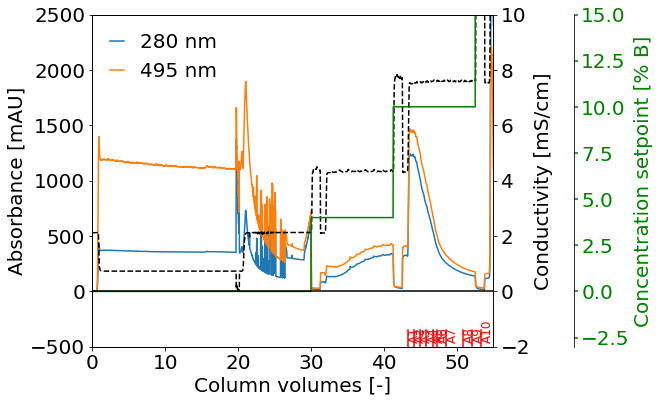

In [11]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(10, 6, forward=True)
ax.set_xlabel('Column volumes [-]')

ax.set_ylabel('Absorbance [mAU]')
ax.plot(df.UV_280nm_cv, df.UV_280nm_mAU, label='280 nm')
ax.plot(df.UV_495nm_cv, df.UV_495nm_mAU, label='495 nm')

ax2 = ax.twinx()
ax2.set_ylabel('Conductivity [mS/cm]')
ax2.plot(df['Cond_cv'], df['Cond_mS/cm'], 'k--')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.set_ylabel('Concentration setpoint [% B]')
ln3, = ax3.plot(df['Conc_cv'], df['Conc_%B'], color='green')
ax3.yaxis.label.set_color(ln3.get_color())
tkw = dict(size=4, width=1.5)
ax3.tick_params(axis='y', colors=ln3.get_color(), **tkw)

xmax = 55
xmin = 0
ax.set_xlim(xmin, xmax)

ax.set_ylim(-500, 2000)
ax2.set_ylim(0, 10)
ax3.set_ylim(0, 15)

align_yaxis_multiple([ax, ax2, ax3])

add_fractions(ax, df, x_conversion=1.0, text=True, xlim_times=(xmin, xmax))

ax.legend(loc='upper left', handlelength=0.7, frameon=False)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig(f'./images/{image_name}.png', dpi=300)

## Scouting with fraction A3
Is there a flow-through "step?"

In [12]:
i = 3
file = files_dic[i]
image_name = file[:file.find('.xls')]
df = data_break[file].df
df.columns

Index(['UV_215nm_ml', 'UV_215nm_mAU', 'UV_280nm_ml', 'UV_280nm_mAU',
       'UV_495nm_ml', 'UV_495nm_mAU', 'Cond_ml', 'Cond_mS/cm', 'Conc_ml',
       'Conc_%B', 'pH_ml', 'pH_', 'Flow_ml', 'Flow_ml/min', 'Temp_ml',
       'Temp_C', 'Inject_ml', 'Inject_(Injections)', 'P960_Flow_ml',
       'P960_Flow_ml/min', 'UV_215nm_cv', 'UV_280nm_cv', 'UV_495nm_cv',
       'Cond_cv', 'Conc_cv', 'pH_cv', 'Flow_cv', 'Temp_cv', 'Inject_cv',
       'P960_Flow_cv'],
      dtype='object')

24.786 -23.6 -16.11641522988506


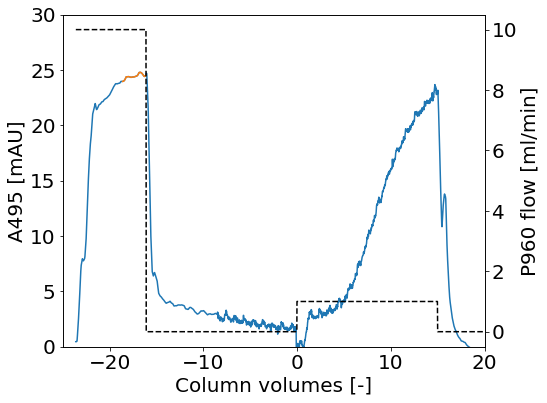

In [13]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

df_mod = df[df['P960_Flow_ml/min'] == df['P960_Flow_ml/min'].max()]
purge_start = df_mod['P960_Flow_cv'].iloc[0]
purge_end = df_mod['P960_Flow_cv'].iloc[-1]

df_search = df[(purge_start < df['UV_495nm_cv']) & (df['UV_495nm_cv'] < purge_end)]
df_search = df_search.tail(int(len(df_search)/3))
max_mau = df_search.UV_495nm_mAU.max()
    
ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU)
ax.plot(df_search.UV_495nm_cv  - df.at[1, 'Inject_cv'], df_search.UV_495nm_mAU)

ax2 = ax.twinx()
ax2.plot(df.P960_Flow_cv  - df.at[1, 'Inject_cv'], df['P960_Flow_ml/min'], 'k--')
ax2.set_ylabel('P960 flow [ml/min]')

# ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(-25, 20)
ax.set_ylim(0, 30)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/FITC-BSA_1B11_scouting.png', dpi=300)

print(max_mau, purge_start- df.at[1, 'Inject_cv'], purge_end- df.at[1, 'Inject_cv'])

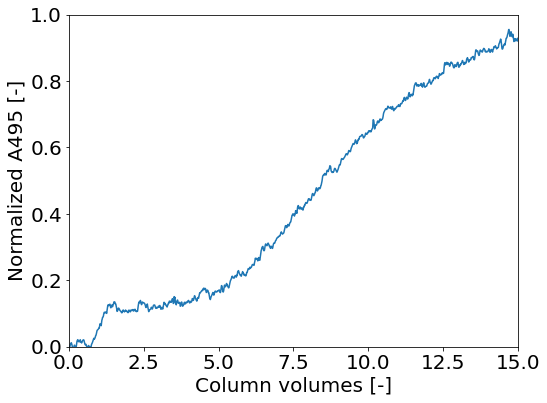

In [14]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('Normalized A495 [-]')

df_mod = df[df['P960_Flow_ml/min'] == df['P960_Flow_ml/min'].max()]
purge_start = df_mod['P960_Flow_cv'].iloc[0]
purge_end = df_mod['P960_Flow_cv'].iloc[-1]

df_search = df[(purge_start < df['UV_495nm_cv']) & (df['UV_495nm_cv'] < purge_end)]
df_search = df_search.tail(int(len(df_search)/3))
max_mau = df_search.UV_495nm_mAU.max()
    
ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU/max_mau)

ax.set_xlim(0, 15)
ax.set_ylim(0, 1)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig(f'./images/{image_name}.png', dpi=300)

# mAb controls at pH 9.5
Does flow-through occur?

In [15]:
plot_dic = {4:'mAb 2', 5:'mAb D'}

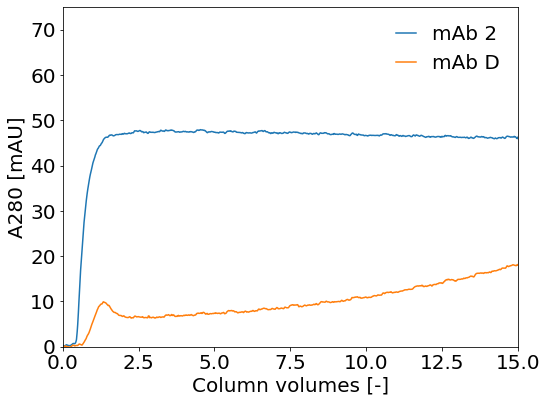

In [16]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

for i, label in plot_dic.items():
    file = files_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, label=label)

ax.legend(loc='upper right', frameon=False, handlelength=1)
ax.set_xlim(0, 15)
ax.set_ylim(0, 75)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/mAb_controls_pH_9.5.png', dpi=300)
# fig.savefig('./images/mAb_controls_pH_9.5_zoomed_out.png', dpi=300)

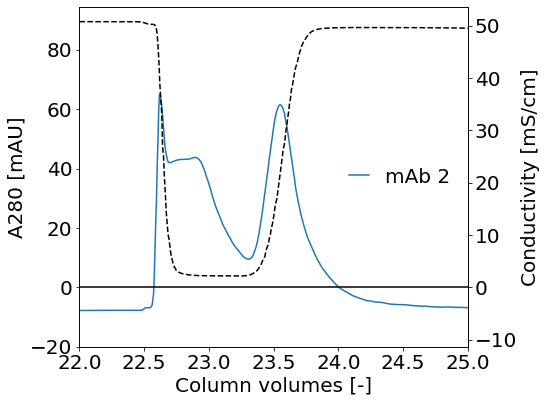

In [17]:
plot_dic = {4:'mAb 2'}
# plot_dic = {4:'mAb 2', 5:'mAb D'}

fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

ax2 = ax.twinx()
ax2.set_ylabel('Conductivity [mS/cm]')

for i, label in plot_dic.items():
    file = files_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, label=label)
    ax2.plot(df.Cond_cv  - df.at[1, 'Inject_cv'], df['Cond_mS/cm'], 'k--')

ax.legend(loc='center right', frameon=False, handlelength=1)
ax.set_xlim(22, 25)
ax.set_ylim(-20, 75)
align_yaxis_multiple([ax, ax2])
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/mAb_2_FT_control_elution.png', dpi=300)


In [18]:
file = files_dic[4]
df = data_break[file].df
df_slice = df[(23.3 < df.UV_280nm_cv) & (df.UV_280nm_cv < 25.0)]
area = integrate.trapz(y=df_slice.UV_280nm_mAU, x=df_slice.UV_280nm_cv)

In [19]:
extinction_mAb_mass = 1.57
mAb_mass = 146000
extinction_mAb = extinction_mAb_mass * mAb_mass # M-1 cm-1

mAb_bound_mg = area * 2 / (1e3 * extinction_mAb) * mAb_mass
mAb_bound_mg

0.0409461964294785

In [20]:
mAb_bound_mg/2

0.02047309821473925

# Re-fractionation
## Re-fractionation of material that was previously buffer-exchanged to pH 8.5

In [21]:
i = 1
file = files_dic[i]
image_name = file[:file.find('.xls')]
df = data_break[file].df

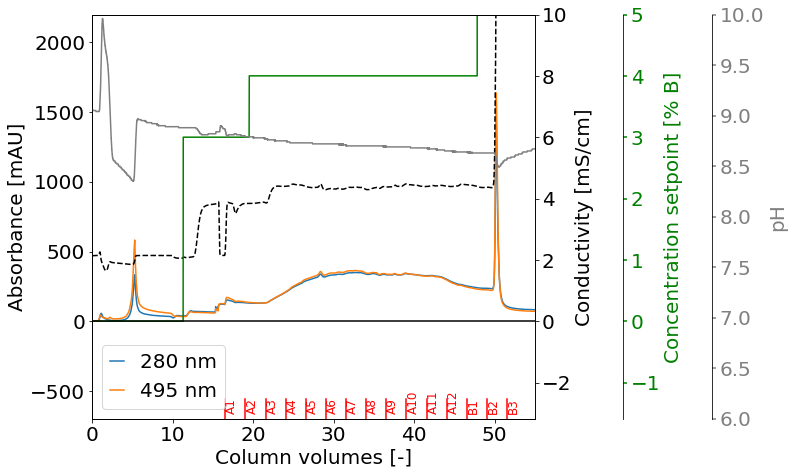

In [22]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(13, 7, forward=True)
ax.set_xlabel('Column volumes [-]')

ax.set_ylabel('Absorbance [mAU]')
ax.plot(df.UV_280nm_cv, df.UV_280nm_mAU, label='280 nm')
ax.plot(df.UV_495nm_cv, df.UV_495nm_mAU, label='495 nm')

ax2 = ax.twinx()
ax2.set_ylabel('Conductivity [mS/cm]')
ax2.plot(df['Cond_cv'], df['Cond_mS/cm'], 'k--')

ax3 = ax.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.set_ylabel('Concentration setpoint [% B]')
ln3, = ax3.plot(df['Conc_cv'], df['Conc_%B'], color='green')
ax3.yaxis.label.set_color(ln3.get_color())
tkw = dict(size=4, width=1.5)
ax3.tick_params(axis='y', colors=ln3.get_color(), **tkw)

ax4 = ax.twinx()
ax4.spines["right"].set_position(("axes", 1.4))
ax4.set_ylabel('pH')
ln4, = ax4.plot(df['pH_cv'], df['pH_'], color='grey')
ax4.yaxis.label.set_color(ln4.get_color())
tkw = dict(size=4, width=1.5)
ax4.tick_params(axis='y', colors=ln4.get_color(), **tkw)

xmax = 55
xmin = 0
ax.set_xlim(xmin, xmax)

ax.set_ylim(-700, 1500)
ax2.set_ylim(0, 10)
ax3.set_ylim(0, 5)
ax4.set_ylim(6, 10)

align_yaxis_multiple([ax, ax2, ax3])

add_fractions(ax, df, x_conversion=1.0, text=True, xlim_times=(xmin, xmax))

ax.legend(loc='lower left', handlelength=0.7, frameon=True)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig(f'./images/{image_name}.png', dpi=300)

## Scouting with A9

In [23]:
i = 2
file = files_dic[i]
image_name = file[:file.find('.xls')]
df = data_break[file].df

16.851 -25.605 -18.121114348142754


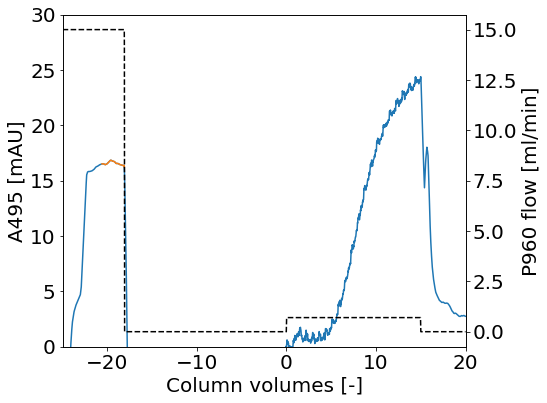

In [24]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

df_mod = df[df['P960_Flow_ml/min'] == df['P960_Flow_ml/min'].max()]
purge_start = df_mod['P960_Flow_cv'].iloc[0]
purge_end = df_mod['P960_Flow_cv'].iloc[-1]

df_search = df[(purge_start < df['UV_495nm_cv']) & (df['UV_495nm_cv'] < purge_end)]
df_search = df_search.tail(int(len(df_search)/3))
max_mau = df_search.UV_495nm_mAU.max()
    
ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU)
ax.plot(df_search.UV_495nm_cv  - df.at[1, 'Inject_cv'], df_search.UV_495nm_mAU)

ax2 = ax.twinx()
ax2.plot(df.P960_Flow_cv  - df.at[1, 'Inject_cv'], df['P960_Flow_ml/min'], 'k--')
ax2.set_ylabel('P960 flow [ml/min]')

# ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(-25, 20)
ax.set_ylim(0, 30)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/FITC-BSA_1B11_scouting.png', dpi=300)

print(max_mau, purge_start- df.at[1, 'Inject_cv'], purge_end- df.at[1, 'Inject_cv'])

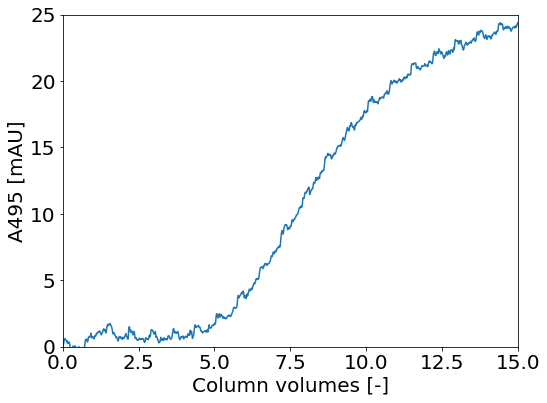

In [25]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU)

ax.set_xlim(0, 15)
ax.set_ylim(0, 25)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig(f'./images/{image_name}.png', dpi=300)

# Pe validation

In [26]:
# plot_dic = {6:'0.5 ml/min', 7:'0.3 ml/min', 8:'0.1 ml/min', 9:'1.0 ml/min', 10:'0.7 ml/min'}
plot_dic = {6:'152 cm/h', 
            7:'91 cm/h', 
            8:'30 cm/h', 
            9:'305 cm/h', 
            10:'213 cm/h'}

## Both A280 and A215

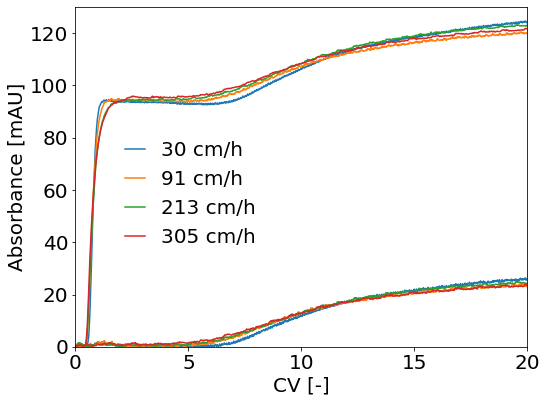

In [27]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV [-]')
ax.set_ylabel('Absorbance [mAU]')

# for i in [8, 7, 6, 10, 9]:
for i in [8, 7, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)
    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, color=plt.gca().lines[-1].get_color())
    

ax.legend(bbox_to_anchor=[0.07, 0.45], frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 130)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/Pe_validation_A280_A495.png', dpi=300)
fig.savefig('./images/Pe_validation_A280_A495_custom.png', dpi=300)

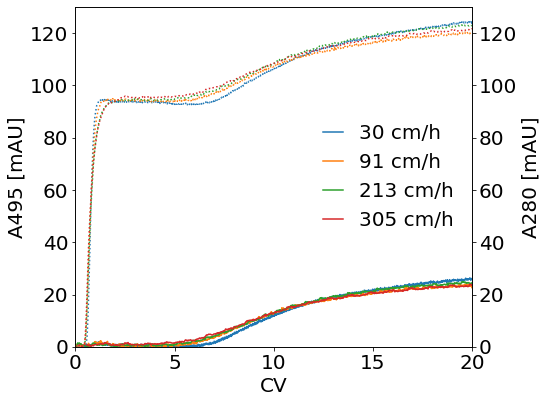

In [28]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV')
ax.set_ylabel('A495 [mAU]')
ax2 = ax.twinx()
ax2.set_ylabel('A280 [mAU]')

# for i in [8, 7, 6, 10, 9]:
for i in [8, 7, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)
    ax2.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, ':') # color=plt.gca().lines[-1].get_color()
    
ax.set_xlim(0, 20)
ax.set_ylim(0, 130)
ax2.set_ylim(0, 130)
ax.legend(frameon=False, handlelength=1, loc='center right')

fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/manuscript_images/A280_and_A495.png', dpi=150)
fig.savefig('./images/manuscript_images/A280_and_A495.pdf')

## A280

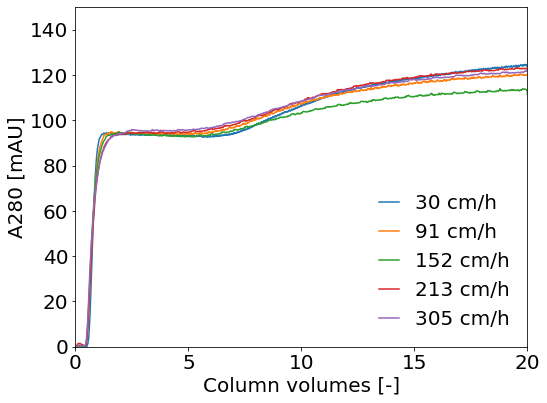

In [29]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, label=label)

ax.legend(loc='lower right', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 150)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A280.png', dpi=300)

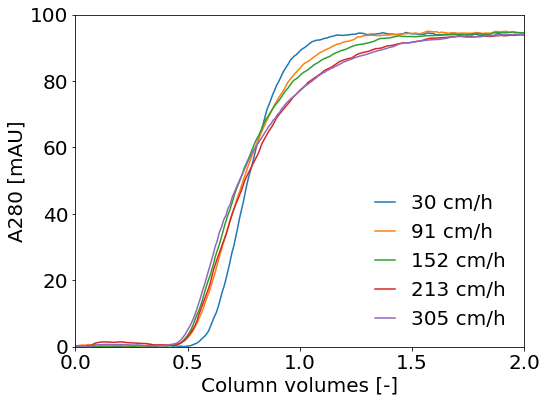

In [30]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, label=label)

ax.legend(loc='lower right', frameon=False, handlelength=1)
ax.set_xlim(0, 2)
ax.set_ylim(0, 100)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A280_zoomed.png', dpi=300)

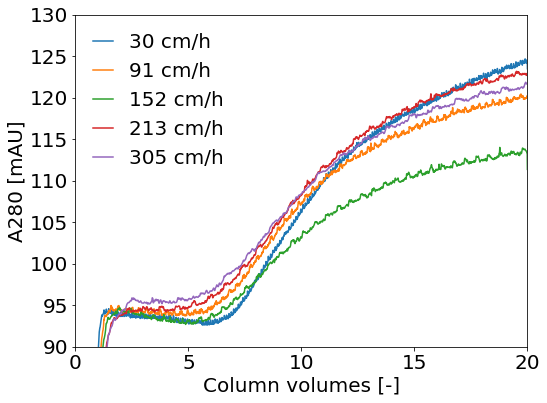

In [31]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df.UV_280nm_mAU, label=label)

ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(90, 130)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A280_zoomed_top.png', dpi=300)

## A495

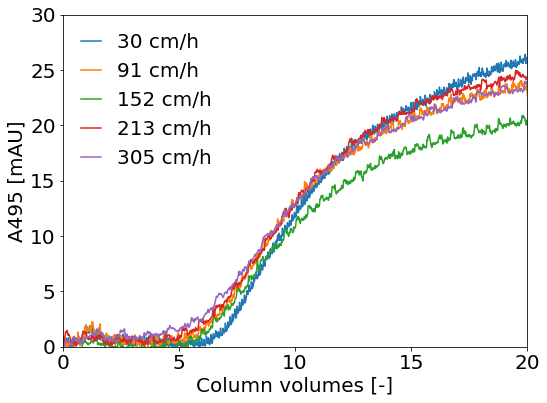

In [32]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)

ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 30)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A495.png', dpi=300)

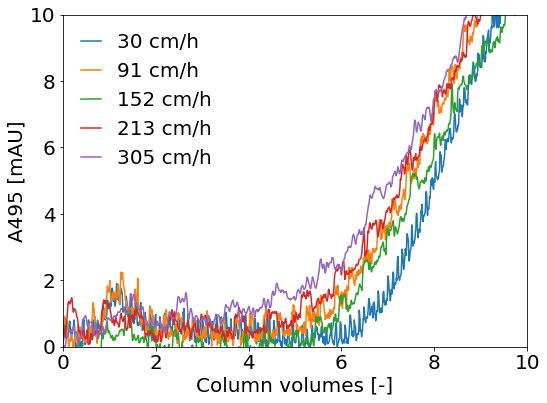

In [33]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)

ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A495_zoomed.png', dpi=300)

### A495 smoothing

In [34]:
from scipy.signal import savgol_filter

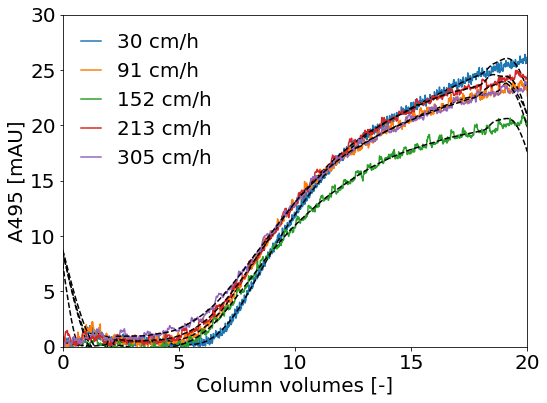

In [35]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df
    
    x = np.array(df.UV_495nm_cv.dropna())
    y = np.array(df.UV_495nm_mAU.dropna())
    yhat = savgol_filter(y, 501, 3)
    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)
    ax.plot(x  - df.at[1, 'Inject_cv'], yhat, 'k--')


ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(0, 20)
ax.set_ylim(0, 30)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/Pe_validation_A495_smoothed.png', dpi=300)

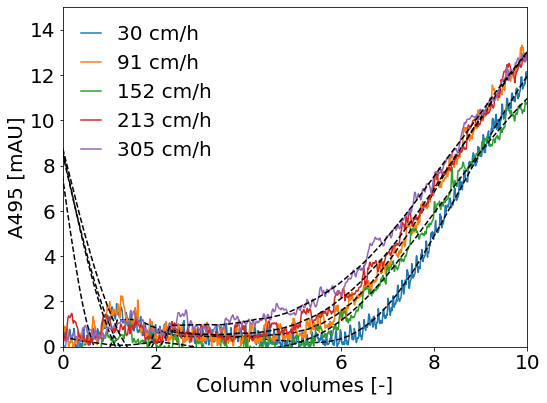

In [36]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    x = np.array(df.UV_495nm_cv.dropna())
    y = np.array(df.UV_495nm_mAU.dropna())
    yhat = savgol_filter(y, 501, 3)
    ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)
    ax.plot(x  - df.at[1, 'Inject_cv'], yhat, 'k--')

ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(0, 10)
ax.set_ylim(0, 15)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A495_zoomed_smoothed_1.png', dpi=300)

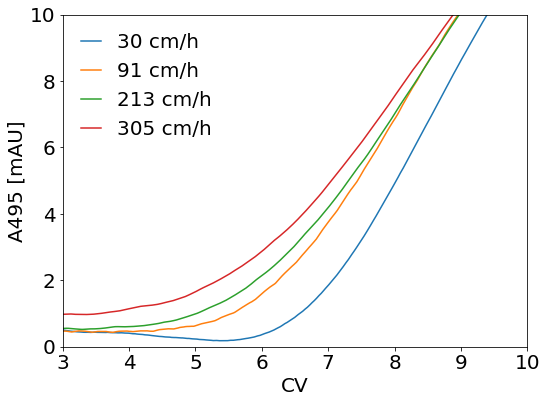

In [37]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('CV')
ax.set_ylabel('A495 [mAU]')

# for i in [8, 7, 6, 10, 9]:
for i in [8, 7, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    x = np.array(df.UV_495nm_cv.dropna())
    y = np.array(df.UV_495nm_mAU.dropna())
    yhat = savgol_filter(y, 501, 3)
#     ax.plot(df.UV_495nm_cv  - df.at[1, 'Inject_cv'], df.UV_495nm_mAU, label=label)
    ax.plot(x  - df.at[1, 'Inject_cv'], yhat, label=label)

ax.legend(loc='upper left', frameon=False, handlelength=1)
ax.set_xlim(3, 10)
ax.set_ylim(0, 10)
fig.patch.set_alpha(1.0)
plt.tight_layout()
# fig.savefig('./images/Pe_validation_A495_zoomed_smoothed_2.png', dpi=300)
# fig.savefig('./images/Pe_validation_A495_zoomed_smoothed_2_custom.png', dpi=300)

fig.savefig('./images/manuscript_images/A495.png', dpi=150)
fig.savefig('./images/manuscript_images/A495.pdf')

## Difference between A280 and A495

In [38]:
for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    df = data_break[file].df
    x = df.UV_280nm_cv.astype('float64')
    xp = df.UV_495nm_cv.astype('float64')
    yp = df.UV_495nm_mAU.astype('float64')
    df['UV_495_mAU_for_280_cv'] = np.interp(x, xp, yp)
    df['280_495_mAU_diff'] = df.UV_280nm_mAU - df.UV_495_mAU_for_280_cv

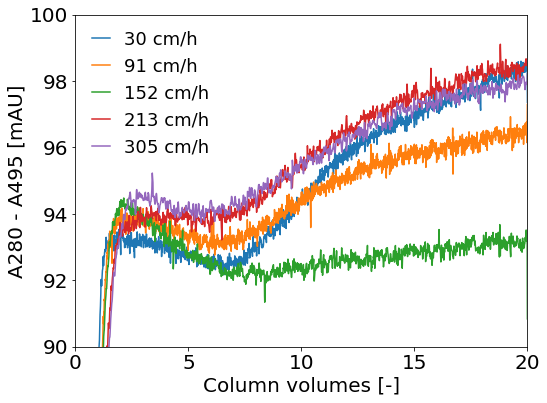

In [39]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('Column volumes [-]')
ax.set_ylabel('A280 - A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    ax.plot(df.UV_280nm_cv  - df.at[1, 'Inject_cv'], df['280_495_mAU_diff'], label=label)    

ax.legend(loc='upper left', frameon=False, handlelength=1, fontsize=18)
ax.set_xlim(0, 20)
ax.set_ylim(90, 100)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A280_A495_difference.png', dpi=300)

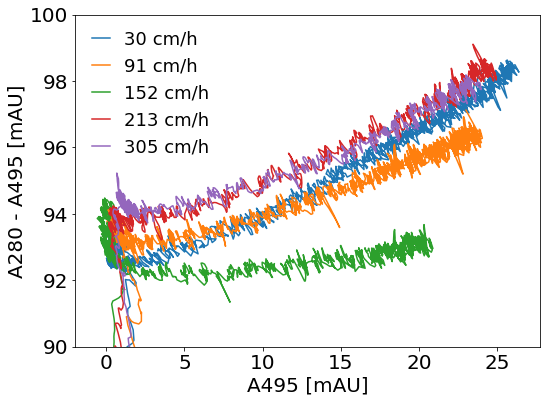

In [40]:
fig, ax = plt.subplots()
font    = {'weight' : 'normal', 'size'   : 20}
plt.rc('font', **font)
fig.set_size_inches(8, 6, forward=True)
ax.set_xlabel('A495 [mAU]')
ax.set_ylabel('A280 - A495 [mAU]')

for i in [8, 7, 6, 10, 9]:
    file = files_dic[i]
    label = plot_dic[i]
    df = data_break[file].df

    df_mod = df[(0 < df.UV_280nm_cv  - df.at[1, 'Inject_cv']) & (df.UV_280nm_cv  - df.at[1, 'Inject_cv'] < 20)]
    ax.plot(df_mod['UV_495_mAU_for_280_cv'], df_mod['280_495_mAU_diff'], label=label)    

ax.legend(loc='upper left', frameon=False, handlelength=1, fontsize=18)
# ax.set_xlim(0, 20)
ax.set_ylim(90, 100)
fig.patch.set_alpha(1.0)
plt.tight_layout()
fig.savefig('./images/Pe_validation_A280_A495_difference_vs_A495.png', dpi=300)

In [41]:
df_mod

,UV_215nm_ml,UV_215nm_mAU,UV_280nm_ml,UV_280nm_mAU,UV_495nm_ml,UV_495nm_mAU,Cond_ml,Cond_mS/cm,Conc_ml,Conc_%B,...,Cond_cv,Conc_cv,pH_cv,Flow_cv,Temp_cv,Fractions_cv,Inject_cv,P960_Flow_cv,UV_495_mAU_for_280_cv,280_495_mAU_diff
1890,36.218827,0.058,36.218827,0.115,36.218827,-0.089,22.634566,4.363,45.217773,4,...,11.317283,22.608887,22.608887,11.317283,45.168286,NaN,NaN,22.643821,-0.089,0.204
1891,36.23799,-0.215,36.23799,0.068,36.23799,0.022,22.646542,4.363,45.241698,4,...,11.323271,22.620849,22.620849,11.323271,45.192185,NaN,NaN,22.655802,0.022,0.046
1892,36.257153,-0.169,36.257153,0.033,36.257153,0.04,22.658518,4.363,45.265623,4,...,11.329259,22.632811,22.632811,11.329259,45.216083,NaN,NaN,22.667783,0.040,-0.007
1893,36.276317,-0.22,36.276317,-0.006,36.276317,0.013,22.670494,4.363,45.289547,4,...,11.335247,22.644774,22.644774,11.335247,45.239982,NaN,NaN,22.679763,0.013,-0.019
1894,36.29548,-0.321,36.29548,-0.003,36.29548,-0.019,22.68247,4.363,45.313472,4,...,11.341235,22.656736,22.656736,11.341235,45.26388,NaN,NaN,22.691744,-0.019,0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3972,76.117026,1172.984,76.117026,121.644,76.117026,23.705,47.568516,4.286,95.029098,100,...,23.784258,47.514549,47.514549,23.784258,NaN,NaN,NaN,47.587966,23.705,97.939
3973,76.136189,1173.359,76.136189,121.634,76.136189,23.682,47.580492,4.287,95.053022,100,...,23.790246,47.526511,47.526511,23.790246,NaN,NaN,NaN,47.599947,23.682,97.952
3974,76.155353,1173.077,76.155353,121.651,76.155353,23.715,47.592468,4.287,95.076947,100,...,23.796234,47.538474,47.538474,23.796234,NaN,NaN,NaN,47.611928,23.715,97.936
3975,76.174516,1175.45,76.174516,121.671,76.174516,23.779,47.604444,4.286,95.100872,100,...,23.802222,47.550436,47.550436,23.802222,NaN,NaN,NaN,47.623909,23.779,97.892
